Fonte dos dados: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

#### Leitura de dados e algumas limpezas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [2]:
# Substitui texto de uma coluna do Dataframe por indice em um
# dicionário
def substituir_valores_por_indice(df, nome_coluna):
    # Montar dicionário dos diferentes valores contidos na coluna
    valores_unicos = df[nome_coluna].unique()
    dicionario_valores = {valor: indice for indice, valor in enumerate(valores_unicos)}

    # Substituir os valores da coluna pelo valor do índice no dicionário
    df[nome_coluna] = df[nome_coluna].map(dicionario_valores)

    return df, dicionario_valores

# filtra colunas que tenham seu equivalente true
def filtrar_colunas_por_booleano(nomes_colunas, booleanos):
    colunas_filtradas = [coluna for coluna, booleano in zip(nomes_colunas, booleanos) if booleano]
    return colunas_filtradas


In [3]:
# Leitura dos dados em um Data frame
df = pd.read_csv('hotel_bookings.csv')
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [4]:
# Lista toda as colunas com campos nulo
print(df.columns[df.isnull().any()])

Index(['children', 'country', 'agent', 'company'], dtype='object')


In [5]:
# Pressupostos:
# Criança: assume-se que não haja quando valor é nulo
# País: assume-se que 'desconhecido' quando valor é nulo
# Criança: assume-se que não haja crianção quando valor é nulo
# Agente: assume-se que não haja quando valor é nulo
# Agencia: assume-se que não criança quando valor é nulo
troca_nan = {"children": 0,"country": "Unknown", "agent": 0, "company": 0}
df = df.fillna(troca_nan)

In [6]:
# Lista toda as colunas com campos nulo
print(df.columns[df.isnull().any()])

Index([], dtype='object')


In [7]:
# "meal" conforme dicionário "Undefined" é o mesmo que 'SC'.
df["meal"].replace("Undefined", "SC", inplace=True)

# Algumas linhas contém o mesmo tempo 0 adults, 0 children and 0 babies. 
# Dropando linhas com 0 hópedes.
zero_guests = list(df.loc[df["adults"]
                   + df["children"]
                   + df["babies"]==0].index)
df.drop(df.index[zero_guests], inplace=True)

In [8]:
# Distribuição de cancelados e não cancelados
df['is_canceled'].value_counts()

is_canceled
0    75011
1    44199
Name: count, dtype: int64

In [9]:
# Quanto dado sobrou? Quantas colunas?
df.shape

(119210, 32)

### a) Elaborar uma análise descritiva da base de dados, análise gráfica e por tabelas.

O principal interesse no problema é compreender como as variáveis condicionais fornecidas se relacionam com o status da variável de interesse *'is_canceled'*, relativa ao cancelamento ou não da reserva.

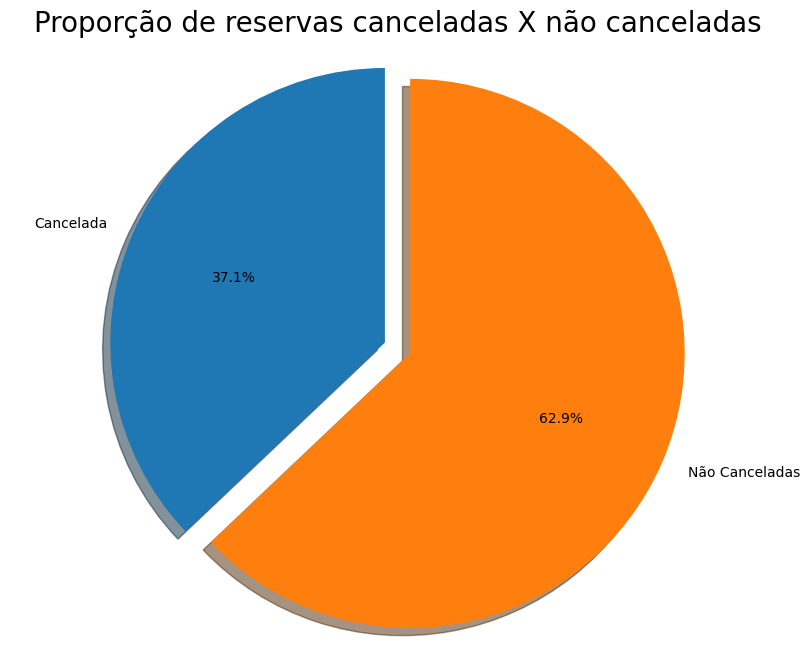

In [10]:
labels = 'Cancelada', 'Não Canceladas'
sizes = [df.is_canceled[df['is_canceled']==1].count(), df.is_canceled[df['is_canceled']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proporção de reservas canceladas X não canceladas", size = 20)
plt.show()

#### Investiga as variáveis categóricas em relação à variavel de interesse

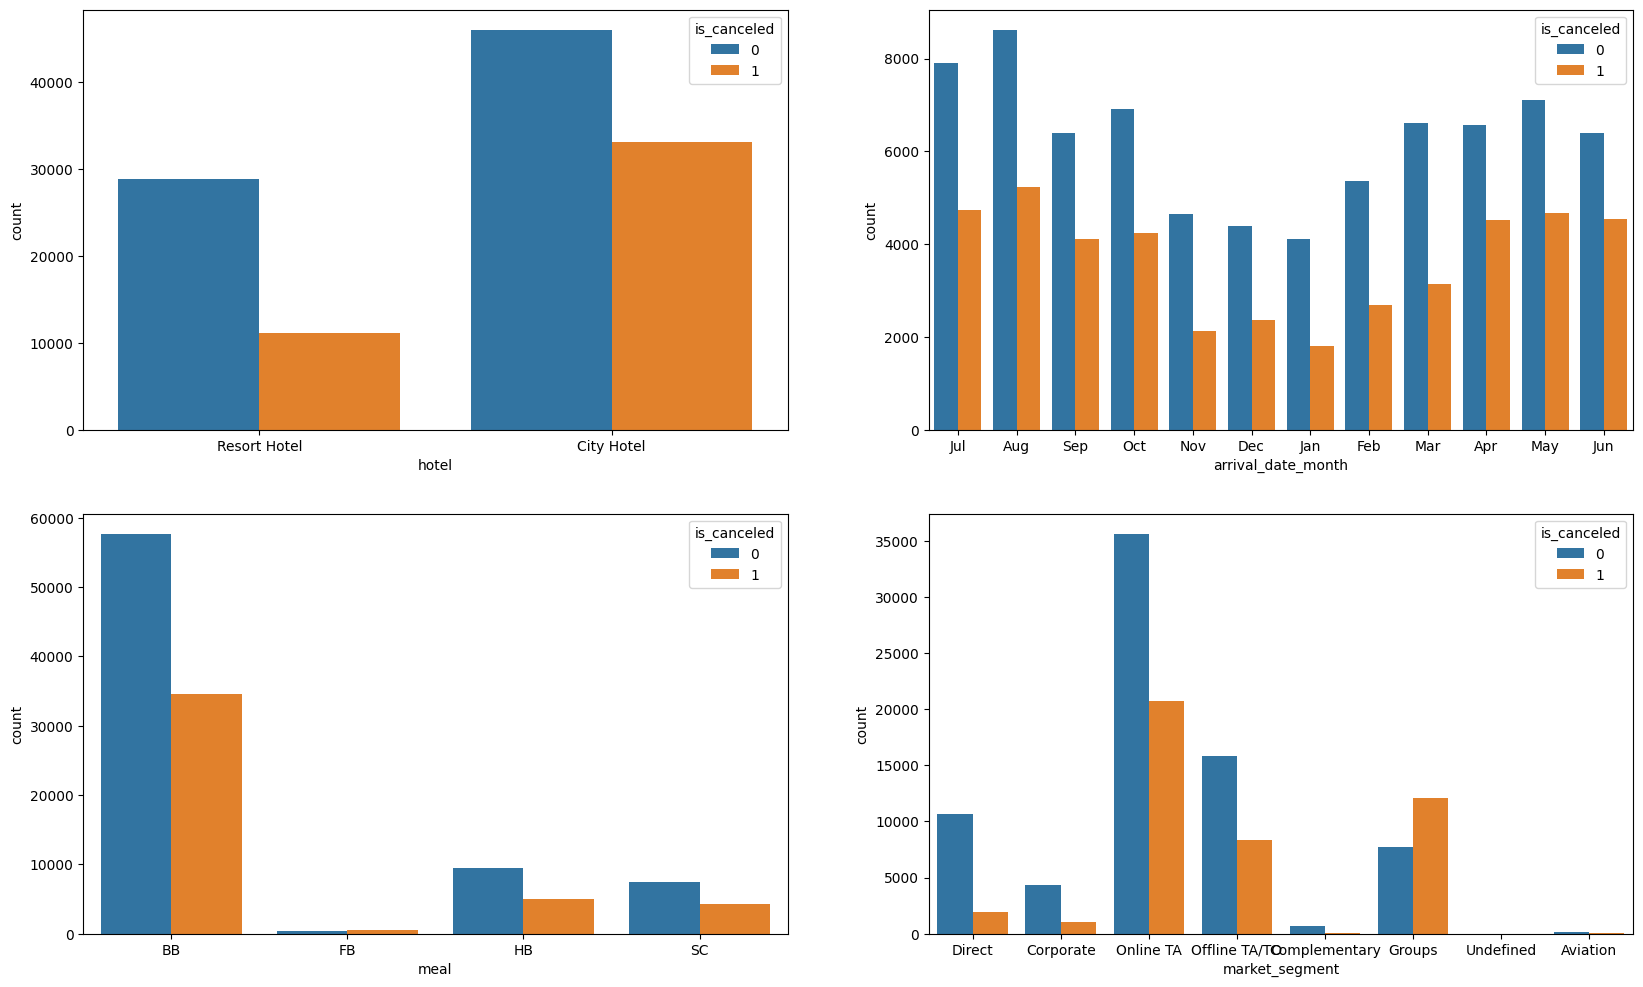

In [11]:
# Variáveis categóricas
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='hotel', hue='is_canceled', data=df, ax=axarr[0][0])
ax = sns.countplot(x='arrival_date_month', hue='is_canceled', data=df, ax=axarr[0][1])
ax.set_xticklabels([item.get_text()[:3] for item in ax.get_xticklabels()])
sns.countplot(x='meal', hue='is_canceled', data=df, ax=axarr[1][0])
sns.countplot(x='market_segment', hue='is_canceled', data=df, ax=axarr[1][1])

plt.show()

#### Análise dos gráficos
Os dados representam apenas as reservas realizadas em dois hotéis, um resort eu um hotel na cidade. Percebe-se no gráfico de contagem de reservas por tipo de hotel que a preferência é pelo hotel na cidade, mas ao analisar a variável de interesse, o cancelamento no resort, proporcionalmente é inferior aos cancelamentos no hotel da cidade.

Quanto a contagem de reservas nos meses do ano, vê-se claramente que o número de reservas durante o inverno europeu é menor em relação as outras épocas do ano, no entanto, o relação entre reservas canceladas e não canceladas parece se manter.

Quanto a categoria de refeições reservadas, a mais frequente é da categoria BB. Mais uma vez, a relação entre reservas canceladas e não canceladas parece se manter, com relação à categoria escolhida.

O Seguimento de Market que agenciou a viagem tem um destaque na preferência de agendamento em agentes de viagem online. Outro destaque significativo é que reservas feitas em grupo tem um nível de cancelamento maior que as reservas confirmadas.


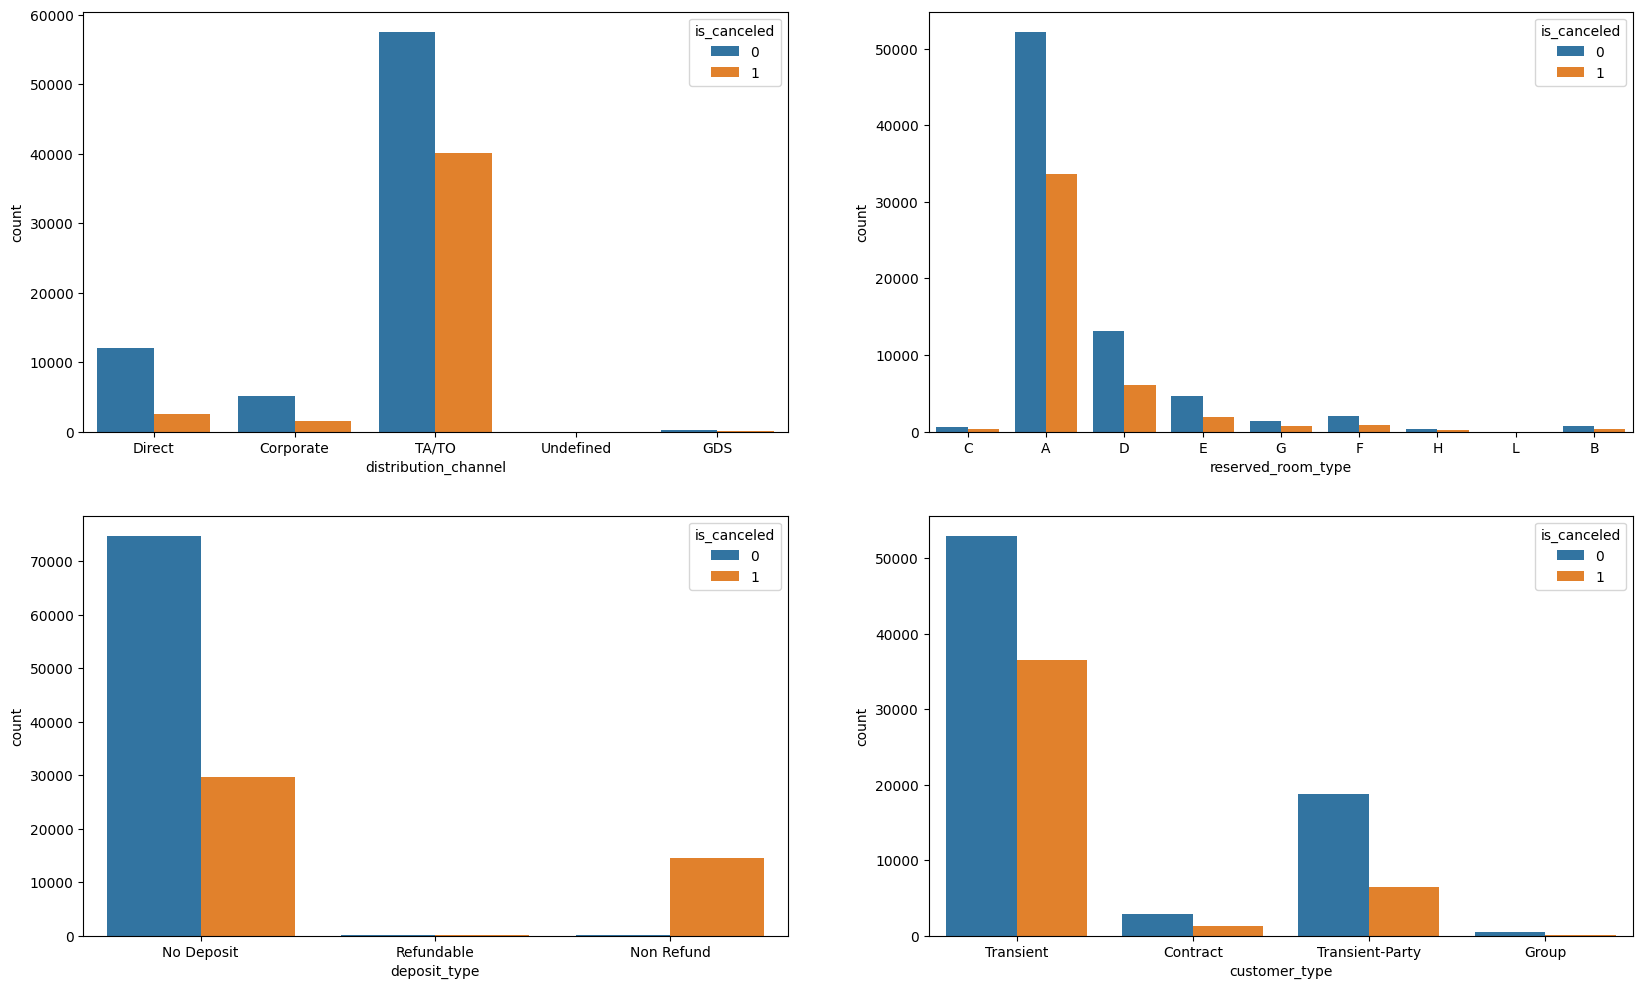

In [12]:
# Mais variáveis categóricas
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='distribution_channel', hue='is_canceled', data=df, ax=axarr[0][0])
sns.countplot(x='reserved_room_type', hue='is_canceled', data=df, ax=axarr[0][1])
sns.countplot(x='deposit_type', hue='is_canceled', data=df, ax=axarr[1][0])
sns.countplot(x='customer_type', hue='is_canceled', data=df, ax=axarr[1][1])

plt.show()

#### Análise dos gráficos
Dos gráficos apresentados, o destaque é a variável “tipo de deposito” para reserva, onde a contagem de cancelamento para depósitos sem devolução é muito alto. O Tipo de quarto preferido é o “A”. O Canal principal para distribuição das reservas é o seguimento Agência/Agente de viagem.

#### Investiga as variáveis contínuas em relação à variavel de interesse

<Axes: xlabel='is_canceled', ylabel='arrival_date_day_of_month'>

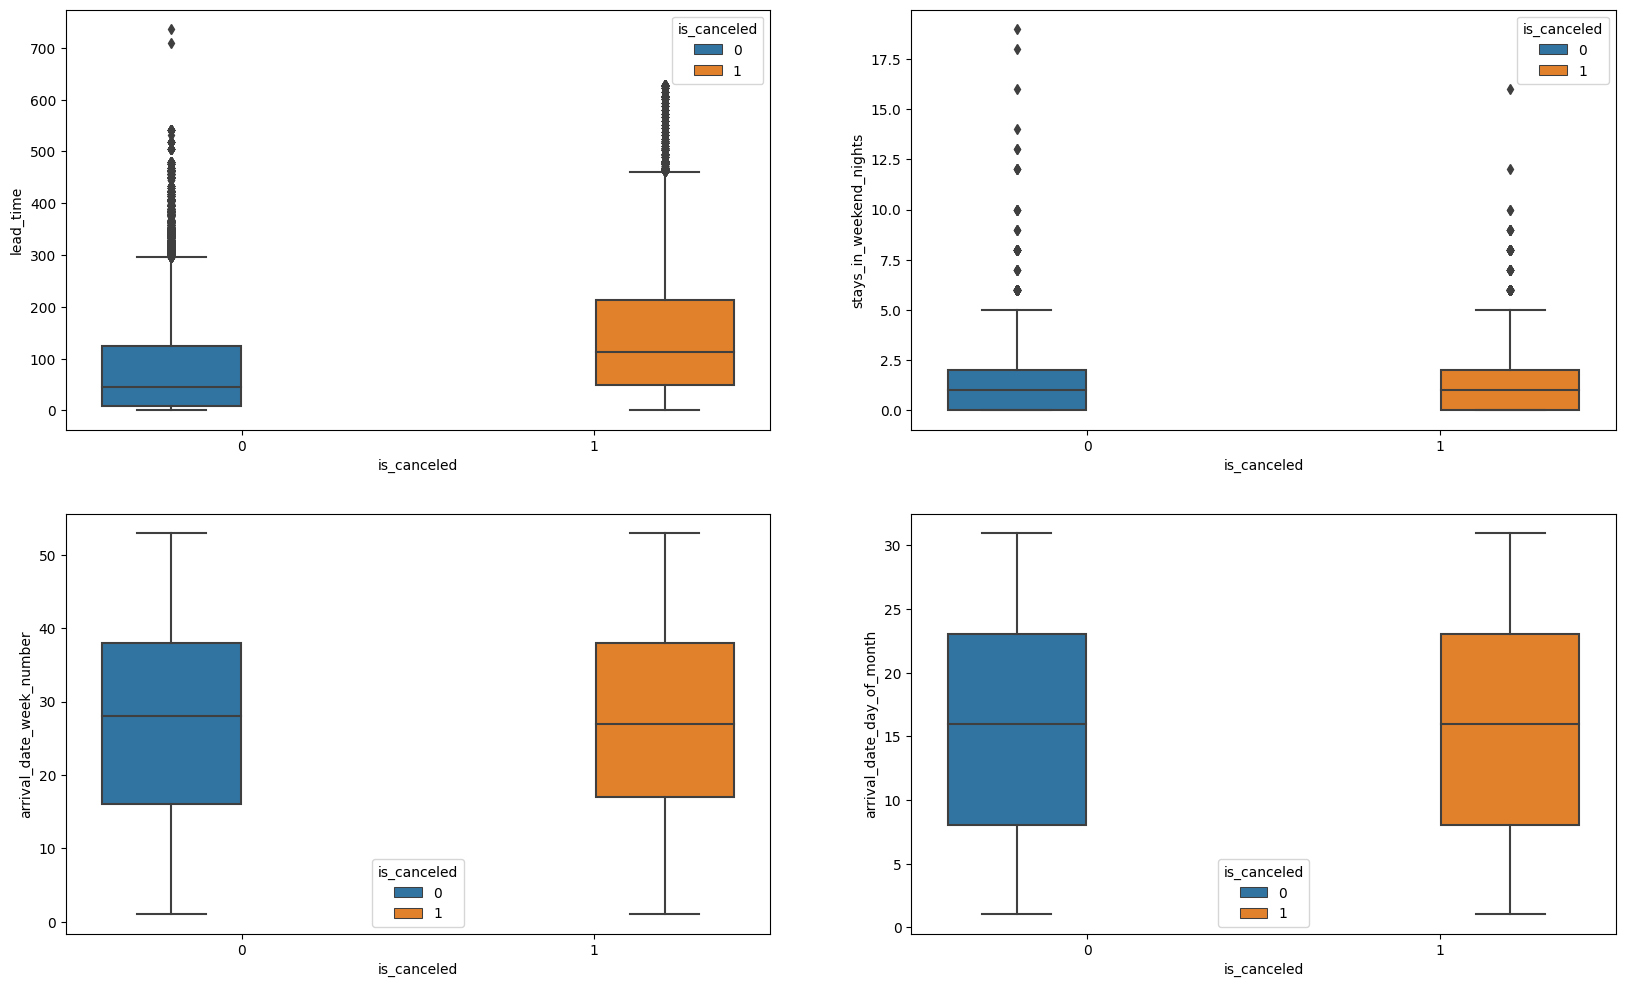

In [13]:
# Revisão da relação entre a variável de interesse e as variáveis contínuas.
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='lead_time',x = 'is_canceled', hue = 'is_canceled',data = df, ax=axarr[0][0])
sns.boxplot(y='stays_in_weekend_nights',x = 'is_canceled', hue = 'is_canceled',data = df , ax=axarr[0][1])
sns.boxplot(y='arrival_date_week_number',x = 'is_canceled', hue = 'is_canceled',data = df, ax=axarr[1][0])
sns.boxplot(y='arrival_date_day_of_month',x = 'is_canceled', hue = 'is_canceled',data = df, ax=axarr[1][1])

### b) Realize a previsão por um modelo de Regressão Logística

#### As seguintes operação são feitas a seguir:
- **Organização a ordem das colunas por tipo de dados**:
    1. Variável de interesse;
    2. Variáveis contínuas;
    3. Variáveis categóricas (discretas).
- **Aplicação do formato *on-hot* e *codificação simétrica*** para as demais variáveis categóricas.

In [14]:
# Organizando as colunas
cont_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "total_of_special_requests", "adr",
                "country", "days_in_waiting_list"]

cate_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type",
                "is_repeated_guest"]


df = df[['is_canceled'] + cont_features + cate_features]
df.head()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,...,days_in_waiting_list,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,is_repeated_guest
0,0,342,27,1,0,0,2,0.0,0,0,...,0,Resort Hotel,July,BB,Direct,Direct,C,No Deposit,Transient,0
1,0,737,27,1,0,0,2,0.0,0,0,...,0,Resort Hotel,July,BB,Direct,Direct,C,No Deposit,Transient,0
2,0,7,27,1,0,1,1,0.0,0,0,...,0,Resort Hotel,July,BB,Direct,Direct,A,No Deposit,Transient,0
3,0,13,27,1,0,1,1,0.0,0,0,...,0,Resort Hotel,July,BB,Corporate,Corporate,A,No Deposit,Transient,0
4,0,14,27,1,0,2,2,0.0,0,0,...,0,Resort Hotel,July,BB,Online TA,TA/TO,A,No Deposit,Transient,0


In [15]:
# usando formato "one-hot" para as demais variáveis categóricas
lst = cate_features
remove = list()
for i in lst:
    if (df[i].dtype == str or df[i].dtype == object):
        for j in df[i].unique():
            df[i+'_'+j] = np.where(df[i] == j,1,0)
        remove.append(i)
df = df.drop(remove, axis=1)
print(df.columns)
print(len(df.columns))

Index(['is_canceled', 'lead_time', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'previous_cancellations', 'previous_bookings_not_canceled', 'agent',
       'company', 'total_of_special_requests', 'adr', 'country',
       'days_in_waiting_list', 'is_repeated_guest', 'hotel_Resort Hotel',
       'hotel_City Hotel', 'arrival_date_month_July',
       'arrival_date_month_August', 'arrival_date_month_September',
       'arrival_date_month_October', 'arrival_date_month_November',
       'arrival_date_month_December', 'arrival_date_month_January',
       'arrival_date_month_February', 'arrival_date_month_March',
       'arrival_date_month_April', 'arrival_date_month_May',
       'arrival_date_month_June', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'market_segment_Direct', 'market_segment_Corporate',
       'market_segment_Online TA', 'market_segment_Offline TA/TO',
      

In [16]:
# Encode para País
tipos_string = df[cont_features].select_dtypes(include='object').dtypes
print(tipos_string)
df, dicionario_country  = substituir_valores_por_indice(df, 'country')
tipos_string = df[cont_features].select_dtypes(include='object').dtypes
print(tipos_string)
print(dicionario_country)

country    object
dtype: object
Series([], dtype: object)
{'PRT': 0, 'GBR': 1, 'USA': 2, 'ESP': 3, 'IRL': 4, 'FRA': 5, 'Unknown': 6, 'ROU': 7, 'NOR': 8, 'OMN': 9, 'ARG': 10, 'POL': 11, 'DEU': 12, 'BEL': 13, 'CHE': 14, 'CN': 15, 'GRC': 16, 'ITA': 17, 'NLD': 18, 'DNK': 19, 'RUS': 20, 'SWE': 21, 'AUS': 22, 'EST': 23, 'CZE': 24, 'BRA': 25, 'FIN': 26, 'MOZ': 27, 'BWA': 28, 'LUX': 29, 'SVN': 30, 'ALB': 31, 'IND': 32, 'CHN': 33, 'MEX': 34, 'MAR': 35, 'UKR': 36, 'SMR': 37, 'LVA': 38, 'PRI': 39, 'SRB': 40, 'CHL': 41, 'AUT': 42, 'BLR': 43, 'LTU': 44, 'TUR': 45, 'ZAF': 46, 'AGO': 47, 'ISR': 48, 'CYM': 49, 'ZMB': 50, 'CPV': 51, 'ZWE': 52, 'DZA': 53, 'KOR': 54, 'CRI': 55, 'HUN': 56, 'ARE': 57, 'TUN': 58, 'JAM': 59, 'HRV': 60, 'HKG': 61, 'IRN': 62, 'GEO': 63, 'AND': 64, 'GIB': 65, 'URY': 66, 'JEY': 67, 'CAF': 68, 'CYP': 69, 'COL': 70, 'GGY': 71, 'KWT': 72, 'NGA': 73, 'MDV': 74, 'VEN': 75, 'SVK': 76, 'FJI': 77, 'KAZ': 78, 'PAK': 79, 'IDN': 80, 'LBN': 81, 'PHL': 82, 'SEN': 83, 'SYC': 84, 'AZE': 85, 'B

In [17]:
# Normaliza variáveis
# normaliza_features = cont_features
# minVec = df[normaliza_features].min().copy()
# maxVec = df[normaliza_features].max().copy()
# df[normaliza_features] = (df[normaliza_features]-minVec)/(maxVec-minVec)
# df.head()

#### Rebalanceando o banco de dados
Nesse passo aplicaremos o algorítmo SMOTE (Synthetic Minority Oversampling Technique) de balanceamento das amostras de treinamento.

O algoritmo SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de balanceamento de classes utilizada em problemas de aprendizado de máquina quando há desequilíbrio entre as classes do conjunto de dados. O desequilíbrio de classes ocorre quando uma classe tem um número significativamente menor de exemplos em relação a outras classes.

In [18]:
col_y = 'is_canceled'
X = df.loc[:, df.columns != col_y]
y = df.loc[:, df.columns == col_y]
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=[col_y])
# Checando as quantidades
print("Tamanho do oversampled é: ",len(os_data_X))
print("Número de não aderência:",len(os_data_y[os_data_y[col_y]==0]))
print("Número de aderência:",len(os_data_y[os_data_y[col_y]==1]))
print("Proporção de não aderência: ",len(os_data_y[os_data_y[col_y]==0])/len(os_data_X)*100, "%")
print("Proporção de aderência:", len(os_data_y[os_data_y[col_y]==1])/len(os_data_X)*100, "%")

Tamanho do oversampled é:  105254
Número de não aderência: 52627
Número de aderência: 52627
Proporção de não aderência:  50.0 %
Proporção de aderência: 50.0 %


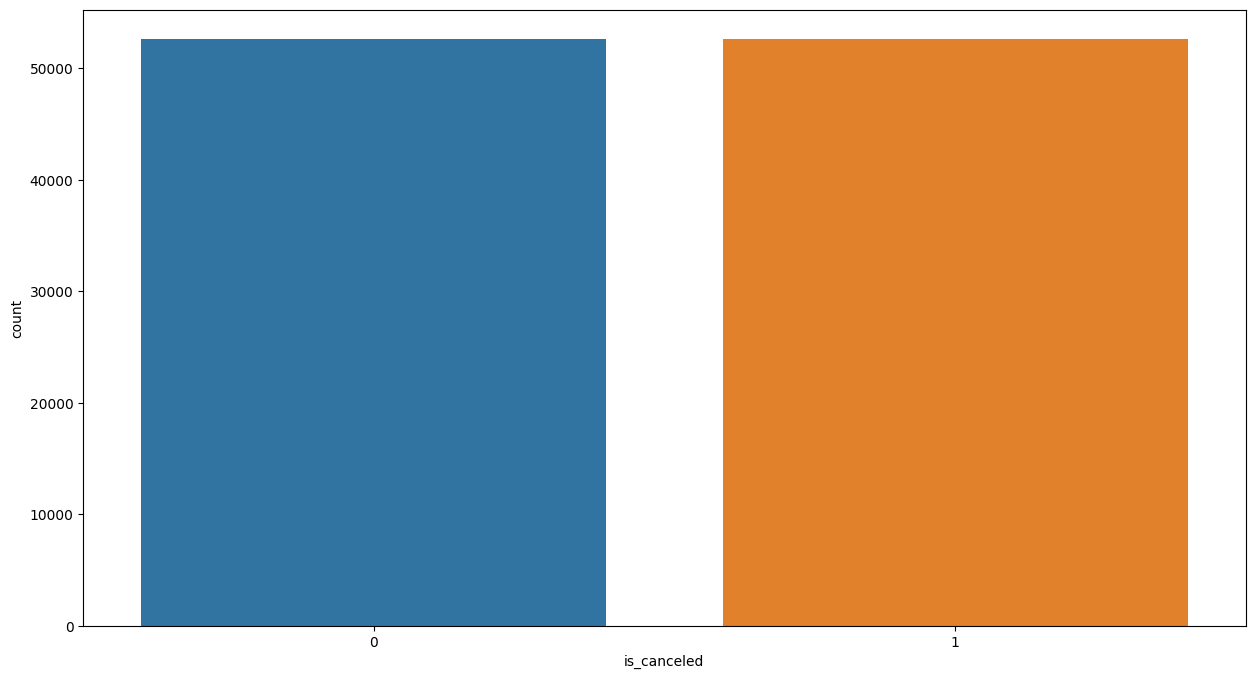

In [19]:
plt.figure(figsize=(15,8))
figure = sns.countplot(x=col_y, data = os_data_y)

In [20]:
# Separa cojunto de amostra de treinamento
X=os_data_X.loc[:, os_data_X.columns != col_y]
y=os_data_y[col_y]
# Separa cojunto de amostra de teste
y_t = y_test[col_y]
X_t = X_test.loc[:, X_test.columns != col_y]

#### Seleção de Variáveis via LOGIT
Recursive Feature Elimination (RFE) é baseada na ideia de repetidamente construir um modelo e selecionar as variáveis que apresentam as melhores e as piores performance. O processo é repetido recursivamente até que sejam selecionadas as variáveis que mais importam para o modelo, de modo a ficar com um número parcimonioso de variáveis.

In [21]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=30)
rfe = rfe.fit(X, y)

print(rfe.support_)
print(rfe.ranking_)

/home/fgaraujofh/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fgaraujofh/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False  True False False False False False False False False
  True  True  True  True  True  True  True False  True False False  True
  True  True  True  True]
[27 32 35 25 21 19 24 22  8 15 29 33 14 26 23 28  9 18 17  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  3  6  5  1  7 31  4 11 12 13 30 10
  1  1  1  1  1  1  1 34  1 20 16  1  1  1  1  1]


/home/fgaraujofh/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# Filtra colunas de features mais significativas
cols = filtrar_colunas_por_booleano(os_data_X.columns.values, rfe.support_)
print(cols)
print(len(cols))

['arrival_date_month_July', 'arrival_date_month_August', 'arrival_date_month_September', 'arrival_date_month_October', 'arrival_date_month_November', 'arrival_date_month_December', 'arrival_date_month_January', 'arrival_date_month_February', 'arrival_date_month_March', 'arrival_date_month_April', 'arrival_date_month_May', 'arrival_date_month_June', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC', 'market_segment_Complementary', 'reserved_room_type_C', 'reserved_room_type_A', 'reserved_room_type_D', 'reserved_room_type_E', 'reserved_room_type_G', 'reserved_room_type_F', 'reserved_room_type_H', 'reserved_room_type_B', 'deposit_type_Non Refund', 'customer_type_Transient', 'customer_type_Contract', 'customer_type_Transient-Party', 'customer_type_Group']
30


In [23]:
df_temp = os_data_X[cols]
# Reatribuindo X e y com colunas restantes
X=os_data_X[cols]
y=os_data_y[col_y]


#### Implementando o LOGIT

In [24]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.517258
         Iterations 10
                                Results: Logit
Model:                  Logit                Method:               MLE        
Dependent Variable:     is_canceled          Pseudo R-squared:     0.254      
Date:                   2023-07-01 18:24     AIC:                  108946.9036
No. Observations:       105254               BIC:                  109233.8276
Df Model:               29                   Log-Likelihood:       -54443.    
Df Residuals:           105224               LL-Null:              -72957.    
Converged:              1.0000               LLR p-value:          0.0000     
No. Iterations:         10.0000              Scale:                1.0000     
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------

In [25]:
log_odds = result.params.values
pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
deposit_type_Non Refund,6.302933
customer_type_Transient,3.061304
customer_type_Transient-Party,2.775798
customer_type_Contract,2.474335
customer_type_Group,1.566422
meal_FB,0.233279
meal_SC,-0.028064
meal_BB,-0.227380
meal_HB,-0.415771
reserved_room_type_B,-0.825422


In [26]:
odds = np.exp(result.params.values)
pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
deposit_type_Non Refund,546.171681
customer_type_Transient,21.355395
customer_type_Transient-Party,16.051426
customer_type_Contract,11.873807
customer_type_Group,4.789481
meal_FB,1.262734
meal_SC,0.972326
meal_BB,0.796618
meal_HB,0.659831
reserved_room_type_B,0.438050


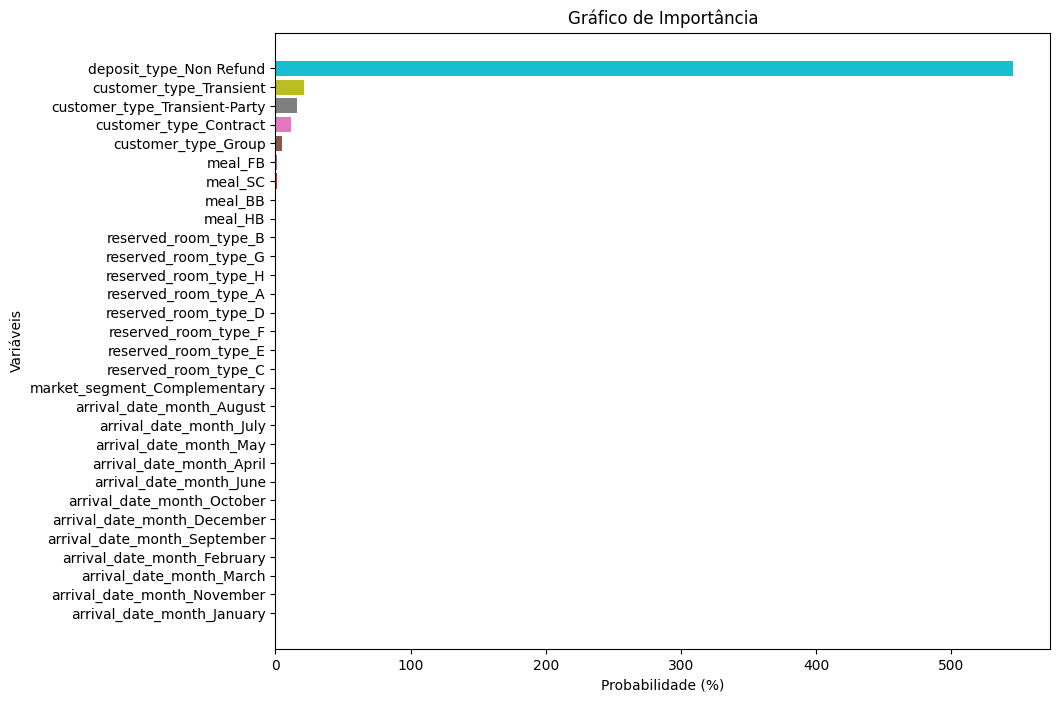

In [27]:
coefficients = pd.DataFrame(odds, X.columns, columns=['coef']).sort_values(by='coef', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(coefficients.index, coefficients['coef'], color=['C{}'.format(i) for i in range(len(coefficients))])
plt.xlabel('Probabilidade (%)')
plt.ylabel('Variáveis')
plt.title('Gráfico de Importância')
plt.show()

In [28]:
logreg = LogisticRegression()
logreg.fit(X_t, y_t)

/home/fgaraujofh/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
y_pred = logreg.predict(X_t)
print('Acurácia do Modelo na Base de Teste: {:.2f}'.format(logreg.score(X_test, y_test)))

Acurácia do Modelo na Base de Teste: 0.79


In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[20011  2373]
 [ 5289  8090]]


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.89      0.84     22384
           1       0.77      0.60      0.68     13379

    accuracy                           0.79     35763
   macro avg       0.78      0.75      0.76     35763
weighted avg       0.78      0.79      0.78     35763



<Figure size 640x480 with 0 Axes>

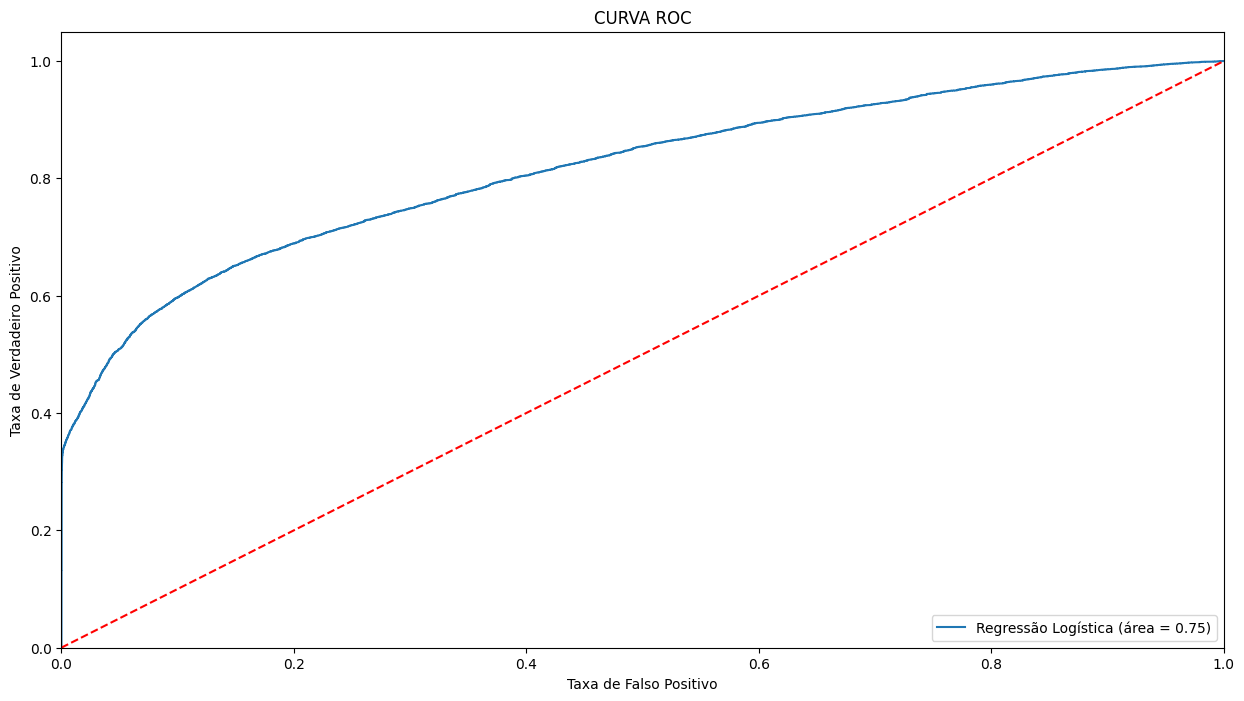

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_t, logreg.predict(X_t))
fpr, tpr, thresholds = roc_curve(y_t, logreg.predict_proba(X_t)[:,1])
plt.figure()
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, label='Regressão Logística (área = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('CURVA ROC')
plt.legend(loc="lower right")
plt.show()